# Run the simulations

In [19]:
!make typical VIEW=Sch -j 3
!make typical VIEW=Lay -j 3

test -d ../../work/xsch || mkdir ../../work/xsch
cd ../../work/ && make xsch LIB=JNW_GREX_SKY130A CELL=JNW_GREX
xschem -q -x -b -s -n ../design/JNW_GREX_SKY130A/JNW_GREX.sch
make[1]: [xsch] Error 10 (ignored)
cp xsch/JNW_GREX.spice xsch/JNW_GREX.spice.bak
cat xsch/JNW_GREX.spice.bak | perl ../tech/script/fixsubckt > xsch/JNW_GREX.spice
rm xsch/JNW_GREX.spice.bak
perl ../../tech/script/genxdut ../../work/xsch/JNW_GREX.spice JNW_GREX
rm dig.so
rm -rf dig_obj_dir
ngspice vlnggen ../../rtl/dig.v
******
** ngspice-44 : Circuit level simulation program
** Compiled with KLU Direct Linear Solver
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2024, The ngspice team.
** Please get your ngspice manual from https://ngspice.sourceforge.io/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
******
- V e r i l a t i o n   R e p o r t: Verilator 5.032 2025-01-01 rev UNKNOWN.REV
- Verilator: Built fr

# Code for plotting curves

The code below uses a single temperature calibration at 20 C to compensate for the offset. 

In [70]:
#!/usr/bin/env python3
import yaml
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot(frun,calvector=None):
    files = list()
    with open(frun) as fi:
        for line in fi:
            if(line.startswith("*")):
                continue
            files.append(line.strip() + ".yaml")

    fig,ax = plt.subplots(nrows=2,ncols=1,sharex=True,height_ratios=[4,1],figsize=(16,9))

    for fname in files:
        with open(fname) as fi:
            obj = yaml.safe_load(fi)
        data = dict()
        vals = list()
        for k in obj:
            if("temp" in k):
                (dd,v) = k.split("temp_")
                dv = int(v)
                val = obj[k]*1000
                #print(val)
                if(val > 128):
                    val = val - 256

                #print(dv,val)
                vals.append([dv,val])
                #if(dv==20):
                #    offset = val
                #    print(offset)

        df = pd.DataFrame(vals, columns=['x','y'])
        df = df.sort_values(by=['x', 'y'])
        df["y"] = df["y"] 

        df["est"] = 0
        if(calvector is None):
            d["est"] = d["y"]
        else:
            for k in range(0,len(calvector)):
                df["est"] += np.power(df["y"],len(calvector)-k-1)*calvector[k]


        diff = df["est"] - df["x"]

        ax[0].plot(df["x"],df["est"],label=fname,marker=".",markersize=10)
        ax[1].plot(df["x"],diff)



    ax[0].set_title(frun.replace(".run",""))
    plt.xlabel("Temperature [C]")
    ax[0].set_ylabel("Estimate [C]")
    ax[1].set_ylabel("Error [C]")
    ax[0].grid()
    ax[1].grid()
    ax[0].legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(frun.replace(".run",".svg"))
    plt.show()

# Typical

The gain (pulse duration back to temperature) is set only in the typical corner. I assume we can measure a single typical (or multiple) devices across temperature

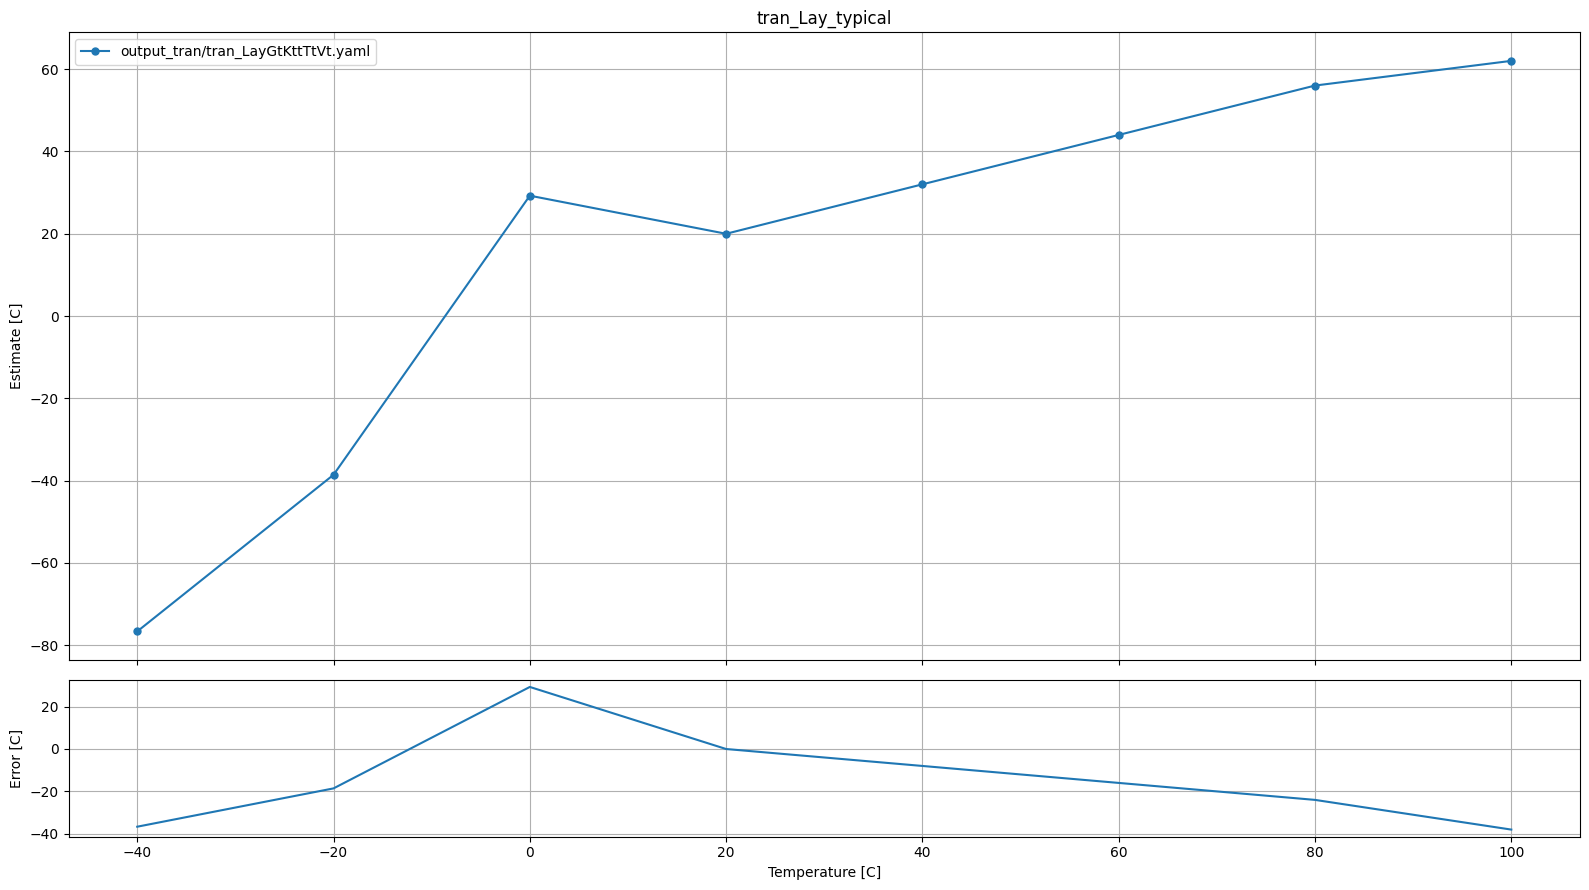

In [71]:
calvector = [1,0]
#plot("tran_Sch_typical.run",calvector)
plot("tran_Lay_typical.run",calvector)

# Slow/Fast

In [22]:
#plot("tran_Sch_tfs.run",calvector)
#plot("tran_Lay_tfs.run",calvector)

FileNotFoundError: [Errno 2] No such file or directory: 'tran_Sch_tfs.run'

# Monte Carlo

In [ ]:
#plot("tran_Sch_mc.run",calvector)
#plot("tran_Lay_mc.run",calvector)